In [ ]:
# uncomment this if running in collab
# !git clone https://github.com/jmourabarbosa/lowrank_tutorial/
# import sys
# sys.path.append('lowrank_tutorial/')

In [3]:
import sys
import matplotlib.pyplot as plt
import torch
import numpy as np
from low_rank_rnns.modules import LowRankRNN,train
from low_rank_rnns import  rdm


plt.rcParams['text.usetex'] = True


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jmourabarbosa/lowrank_tutorial/blob/main/tutorial2.ipynb)

### Goals of this tutorial:

1. Train (or import a trained) network on the random-dots task
2. Reverse egineer the solution found with gradient descent:

    2.1 Solve two equations, instead N: $\kappa$ and input.

    2.2 Sample a different network that lose all neuron specificity but keeps the geometric arrangement between the network vectors. This network solves the task in the same way.

This tutorial is heavily based on the paper and code provided in https://github.com/adrian-valente/populations_paper_code/.

For the porpuse of this tutorial, we will try to abstract completely the fine art of training RNNs and focus on its analyses.
You can find many tutorial on how to train RNNs online. I recommend you take a look at neurogym: https://neurogym.github.io/

***Exercise 1.***

The following code initializes a rank 1 RNN and generates 1000 trials from the random dots task.

* load and plot 2 trials (coherence 1 and -1) from random dots task
* run the network with these 2 trials
* check single neurons and mean activity of the network
* extract the important vectors of the RNN (m, n, wi, wo) - what is their relationship?
* What is the output (i.e. of projection of ativity onto wo) of the untrained network?


In [4]:

x_train, y_train, mask_train, x_val, y_val, mask_val = rdm.generate_rdm_data(1000)
time = np.arange(x_train.shape[1]) * rdm.deltaT / 1000
stim_idx = np.zeros_like(time)
stim_idx[rdm.fixation_duration_discrete:rdm.stimulus_end] = 1

net = LowRankRNN(input_size=1, hidden_size=512, output_size=1, noise_std = 5e-2, alpha=0.2, train_wi=False, train_wo=False, rank=1)
#train(net, x_train, y_train, mask_train, lr=5e-3, n_epochs=20, batch_size=32, keep_best=True, cuda=True)
net.load_state_dict(torch.load(f'models/rdm_lr_fig2.pt', map_location='cpu'))

m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy()
wi = net.wi_full[0].detach().numpy()
wo = net.wo_full[:,0].detach().numpy()

# n=-n
# m=-m

(-0.05, 1.05, -2.0, 2.0)

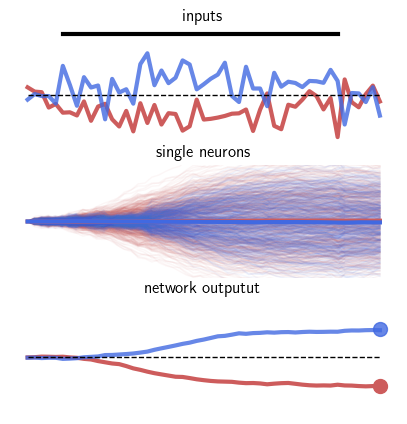

In [5]:

colors = ['indianred','royalblue']

# Generate two trials and network response
x1, y1, mask1, _, _, _ = rdm.generate_rdm_data(1, coherences=[-1], fraction_validation_trials=0.)
x2, y2, mask2, _, _, _ = rdm.generate_rdm_data(1, coherences=[1], fraction_validation_trials=0.)
output1, hidden_states1 = net.forward(x1, return_dynamics=True)
output2, hidden_states2 = net.forward(x2, return_dynamics=True)

output1 = output1.detach().squeeze().numpy()
output2 = output2.detach().squeeze().numpy()
hidden_states1 = hidden_states1.detach().squeeze().numpy()
hidden_states2 = hidden_states2.detach().squeeze().numpy()
x1 = x1.squeeze().numpy()
x2 = x2.squeeze().numpy()
y1 = y1.squeeze().numpy()
y2 = y2.squeeze().numpy()

plt.figure(figsize=(5,5))
plt.subplot(3,1,1)
plt.title("inputs")
plt.plot(time, x1, c=colors[0], lw=3)
plt.plot(time, x2, c=colors[1], lw=3, alpha=.8)
plt.plot(time,np.zeros_like(time), "k--", lw=1)
plt.plot(time[stim_idx==1], np.ones_like(time[stim_idx==1]) * 0.5, "k", lw=3)
plt.axis("off")

plt.subplot(3,1,2)
plt.title("single neurons")
plt.plot(hidden_states1[:,:], lw=1, c=colors[0],alpha=.05)
plt.plot(hidden_states2[:,:], lw=1, c=colors[1],alpha=.05)

plt.plot(np.mean(hidden_states1,1), lw=3, c=colors[0])
plt.plot(np.mean(hidden_states2,1), lw=3, c=colors[1])
plt.ylim(-2, 2)
plt.axis("off")

plt.subplot(3,1,3)
plt.title("network outputut")
plt.plot(time, output1, lw=3, c=colors[0])
plt.plot(time, output2, lw=3, c=colors[1], alpha=.8)
plt.plot(time[-1], y1[-1], "o", ms=10,c=colors[0], lw=3)
plt.plot(time[-1], y2[-1], "o", ms=10,c=colors[1], lw=3, alpha=.8)
plt.plot(time,np.zeros_like(time), "k--", lw=1)
plt.ylim(-2, 2)
plt.axis("off")


***Exercise 2.***

* train a network (or load a trained network) network on the task
* check the network output and single neuron activity
* what changed in the network vectors? (hint: look at their geometric relationship, ie the overlaps)

***Exercise 3.***

The following code initializes 4 different inputs, each with difference coherence levels.

* run the trained network with these 4 inputs and save the hidden units activity
* project the hidden states of each of these trials into the m-I plance (hint: remember to orthogonlize I with respect to m)
* (bonus): project the n and I vector in this plane.


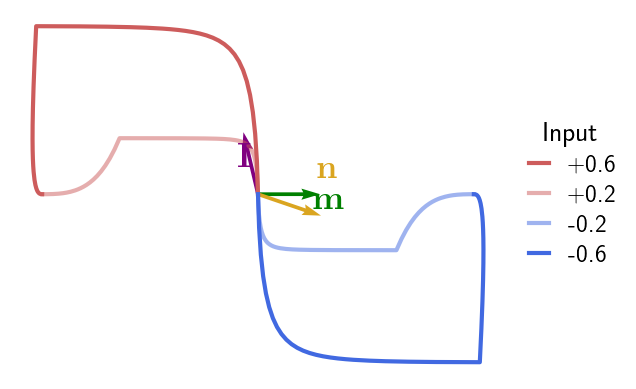

In [6]:

net.noise_std = 0.

inputs = torch.zeros((4, rdm.total_duration + 100, 1))
inputs[0, rdm.fixation_duration_discrete:rdm.stimulus_end] += .2 * rdm.SCALE
inputs[1, rdm.fixation_duration_discrete:rdm.stimulus_end] += .6 * rdm.SCALE
inputs[2, rdm.fixation_duration_discrete:rdm.stimulus_end] += -.2 * rdm.SCALE
inputs[3, rdm.fixation_duration_discrete:rdm.stimulus_end] += -.6 * rdm.SCALE

_, hidden_states = net.forward(inputs, return_dynamics=True)
hidden_states = hidden_states.detach().squeeze().numpy()

i_orth = wi - (wi @ m) * m / (m @ m)
proj1 = hidden_states @ m / (m @ m)
proj2 = hidden_states @ i_orth / (i_orth @ i_orth)

plt.plot(proj1[1], proj2[1], lw=3, label='+0.6', c=colors[0])
plt.plot(proj1[0], proj2[0], lw=3, label='+0.2', c=colors[0], alpha=.5)
plt.plot(proj1[2], proj2[2], lw=3, label='-0.2', c=colors[1], alpha=.5)
plt.plot(proj1[3], proj2[3], lw=3, label='-0.6', c=colors[1])
plt.axis('off')

plt.quiver(0, 0, 1, 0, scale=8, color='green')
plt.quiver(0, 0, wi @ m / (m @ m), wi @ i_orth / (i_orth @ i_orth), scale=8, color='purple')
plt.quiver(0, 0, n @ m / (m @ m), n @ i_orth / (i_orth @ i_orth), scale=5, color='goldenrod')
plt.text(-.05, .01, '$\mathbf{I}$', size=25, color='purple')
plt.text(.14, -.005, '$\mathbf{m}$', size=25, color='green')
plt.text(.15, .006, '$\mathbf{n}$', size=25, color='goldenrod')
plt.legend(bbox_to_anchor=(1., .5), loc='center left', labelspacing=.3, handlelength=.8, title='Input', 
          fontsize=18, title_fontsize=20, frameon=False)
# net.noise_std = noise_std
# # plt.savefig('figure_2/rdm_hidden_statesectories.pdf', bbox_inches='tight')

***Exercise 4.***
Recall yesterday's tutorial equation for $\kappa$:

$$ \dot \kappa = -k + \frac{1}{N}n^T\phi(\kappa m + v I) \; \; \; \small (2)$$
$$ \dot v = -v + u I$$


* Using what you learned from yesterday's tutorial, potentially using the same code, integrate $\dot \kappa$ and $\dot v$.
* How good is the match between the network activity and this 2D system?
* (bonus) How could you recover the high-dimensional system (n=512) from this low-d (n=2)?


In [7]:
dt =  net.alpha
def phi(x):

  return np.tanh(x)

u = inputs[1]

N = 512 

k_ = np.zeros([4])
v_ = np.zeros([4])

K = np.zeros((4,rdm.total_duration + 100))
V = np.zeros((4,rdm.total_duration + 100))

for ti in range(rdm.total_duration + 100):
  for ui,u in enumerate(inputs):
    v_[ui] = v_[ui] + dt*(-v_[ui] + u[ti])
    k_[ui] = k_[ui] + dt*(-k_[ui] + 1/N*n.T @ phi(k_[ui]*m + v_[ui]*wi))
  
  K[:,ti] = k_
  V[:,ti] = v_


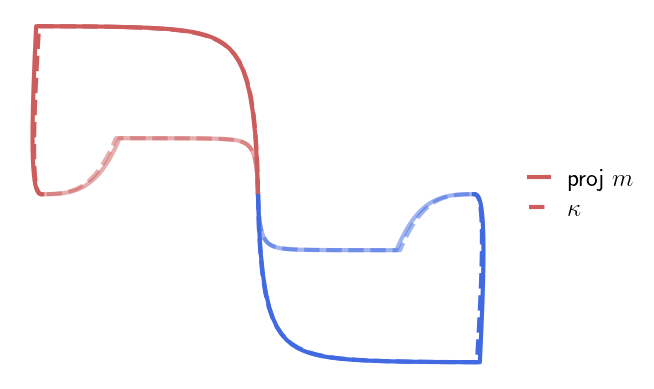

In [8]:
plt.plot(proj1[1], proj2[1], lw=3, label="proj $m$",c=colors[0])
plt.plot(proj1[0], proj2[0], lw=3, c=colors[0], alpha=.5)
plt.plot(proj1[2], proj2[2], lw=3, c=colors[1], alpha=.5)
plt.plot(proj1[3], proj2[3], lw=3, c=colors[1])

plt.plot(K[1], V[1], "--",lw=3, label="$\kappa$", c=colors[0])
plt.plot(K[0], V[0], "--",lw=3, c=colors[0], alpha=.5)
plt.plot(K[2], V[2], "--",lw=3, c=colors[1], alpha=.5)
plt.plot(K[3], V[3], "--",lw=3, c=colors[1])
plt.axis('off')

plt.legend(bbox_to_anchor=(1., .5), loc='center left', labelspacing=.3, handlelength=.8,
          fontsize=18, title_fontsize=20, frameon=False)

***Exercise 5.***

Recall yesterday's lecture first exercise:

"An important insight of the low-rank RNN theory is that the alignment between the vectors definning the RNN (in this case $m,n,I$) fully determine the dynamics performed by the network."

For the final exercise we will do an empirical (but very strong!) demonstration of this statement. 

Specifically, we will sample a new network that keeps the geometric relationshops of its vectors, but mixes everything else.

* calculate the mean and covariances of all the network vectors (m,n,wi,wo)
* sample a new set of vectors from a multivariance gaussian with that mean and covariance (hint: use np.random.multivariate_normal)
* what is the relationship of these new vectors relative to the new ones? 
* use these new vectors to initialize a new network (either using the helper LowRankRNN or integrating it with euler as we did yesterday)
* perform analyses to convice yourself this network also solves the task
* (bonus) calculate psychometric curves for each network 

In [9]:


vects = np.array([m,n,wi,wo])
means = np.mean(vects,1)
overlaps = np.cov(vects - means[:,None])
_m,_n,_wi,_wo = torch.Tensor(np.random.multivariate_normal([0,0,0,0], np.cov(vects), size=N).T + means[:,None])

net2 = LowRankRNN(input_size=1, hidden_size=512, output_size=1, noise_std = 5e-2, alpha=0.2, n_init=_n[:,None],m_init=_m[:,None],wo_init=_wo[:,None],wi_init=_wi[None,:],train_wi=False, train_wo=False, rank=1)


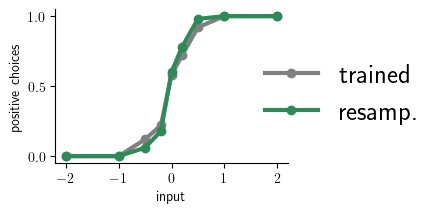

In [10]:
cohs = [-2, -1, -.5, -.2, 0., .2, .5, 1, 2]
probs_trained = []
probs_reconstructed = []
probs_res = []
fig, ax = plt.subplots(figsize=(3., 2))

# Trained net
for coh in cohs:
    input, target, _, _, _, _ = rdm.generate_rdm_data(50, coherences=[coh], fraction_validation_trials=0)
    with torch.no_grad():
        output = net(input)
        decisions = (torch.sign(output[:, rdm.response_begin:, 0].mean(dim=1).squeeze()) + 1) // 2
        probs_trained.append(decisions.mean().item())
        
        output = net2(input)
        decisions = (torch.sign(output[:, rdm.response_begin:, 0].mean(dim=1).squeeze()) + 1) // 2
        probs_res.append(decisions.mean().item())
        
ax.plot(np.array(cohs), probs_res, c='gray', lw=3, label='trained', marker='o')
ax.plot(np.array(cohs), probs_trained, c='seagreen', lw=3, label='resamp.', marker='o')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0., .5, 1.])
ax.set_xlabel('input')
ax.set_ylabel('positive choices')
ax.legend(frameon=False, fontsize=19, bbox_to_anchor=(.8, .8))


## Bonus: train a network a more complex task